In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# https://drive.google.com/file/d/1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z/view?usp=sharing
!gdown --id 1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z
To: /content/image_retrieval_dataset.zip
100% 36.5M/36.5M [00:00<00:00, 173MB/s]


In [ ]:
!unzip image_retrieval_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_mr/5415.jpg      
  inflating: images_mr/5416.jpg      
  inflating: images_mr/5417.jpg      
  inflating: images_mr/5418.jpg      
  inflating: images_mr/5419.jpg      
  inflating: images_mr/542.jpg       
  inflating: images_mr/5420.jpg      
  inflating: images_mr/5421.jpg      
  inflating: images_mr/5422.jpg      
  inflating: images_mr/5423.jpg      
  inflating: images_mr/5424.jpg      
  inflating: images_mr/5425.jpg      
  inflating: images_mr/5426.jpg      
  inflating: images_mr/5427.jpg      
  inflating: images_mr/5428.jpg      
  inflating: images_mr/5429.jpg      
  inflating: images_mr/543.jpg       
  inflating: images_mr/5430.jpg      
  inflating: images_mr/5431.jpg      
  inflating: images_mr/5432.jpg      
  inflating: images_mr/5433.jpg      
  inflating: images_mr/5434.jpg      
  inflating: images_mr/5435.jpg      
  inflating: images_mr/5436.jpg      
  inflating: images_mr/5437.jpg      

## 1. Import libraries

In [ ]:
!pip install transformers==4.31.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

## 2. Load dataset

In [ ]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)[:500]
src_images = []
for filename in image_filenames:
    filepath = os.path.join(
        dataset_dir,
        filename
    )

    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    src_images.append(image)

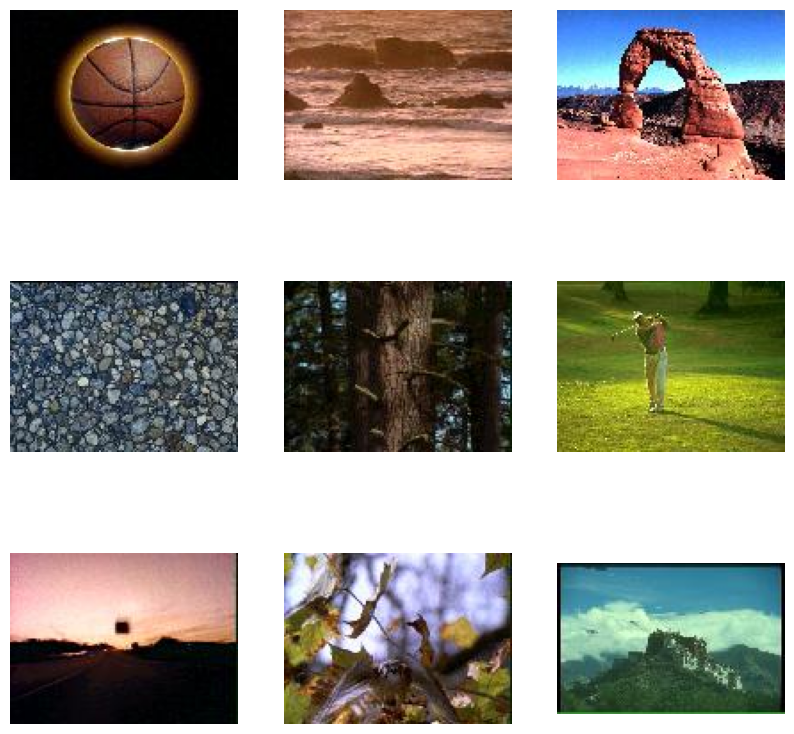

In [ ]:
# Show some images
n_rows = 3
n_cols = 3
visualize_idx = 0

fig, ax = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(10, 10)
)

for idx in range(n_rows):
    for jdx in range(n_cols):
        ax[idx, jdx].imshow(src_images[visualize_idx])
        ax[idx, jdx].axis('off')
        visualize_idx += 1

## 3. Preprocess images

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224").to(device)

def preprocessing(images):
    inputs = processor(
        images,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        output = model(
            **inputs,
            output_hidden_states=True
        ).hidden_states[-1][:, 0, :].detach().cpu().numpy()

    return output

In [ ]:
preprocessed_src_images = preprocessing(src_images)

## 4. Define similarity metric

In [ ]:
def mean_absolute_error(query_vector, src_vectors):
    abs_diff = np.abs(src_vectors - query_vector)
    mae = np.mean(abs_diff, axis=1)

    return mae

def mean_squared_error(query_vector, src_vectors):
    squared_diff = (src_vectors - query_vector) ** 2
    mse = np.mean(squared_diff, axis=1)

    return mse

def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector / query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1)
    normalized_src = src_vectors / src_norms[:, np.newaxis]

    cosine_similarity = np.dot(normalized_src, normalized_query)

    return cosine_similarity

def correlation_coefficient(query_vector, src_vectors):
    return np.corrcoef(query_vector, src_vectors)[:-1, -1]

In [ ]:
test_query = preprocessed_src_images[0]

cosine_similarity(test_query, preprocessed_src_images)

array([ 1.        ,  0.02270719,  0.09533311,  0.11853416,  0.06128163,
        0.10429107,  0.0966341 ,  0.09495853,  0.08440311,  0.03823107,
        0.08391678, -0.00722653, -0.02662338,  0.10114511,  0.14843789,
        0.16436632,  0.14146113,  0.05014776,  0.13934101,  0.02148323,
        0.16426073,  0.10668832,  0.02775724,  0.07009355,  0.08967586,
        0.03964863,  0.07443331,  0.16690418,  0.09190914,  0.07770295,
        0.07035947,  0.04388314,  0.08642193,  0.70611477,  0.16510314,
        0.11880256,  0.11695071,  0.23132083,  0.18275096,  0.05419158,
        0.12608498,  0.08098117,  0.07866302,  0.14513169,  0.12395498,
        0.07286961,  0.03431928,  0.12713555,  0.07611225,  0.10083783,
        0.0681982 ,  0.08714241,  0.06861754,  0.03447122,  0.05851918,
        0.14643148,  0.09552824,  0.15653458,  0.088193  ,  0.07512444,
        0.11510072,  0.3278115 ,  0.07722718,  0.04992383,  0.1064788 ,
        0.04433707,  0.10396172,  0.07883794,  0.1931915 ,  0.04

## 5. Ranking

In [ ]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
    scores = cosine_similarity(
        preprocessed_query_image,
        preprocessed_src_images
    )
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]

    return ranked_list, scores

Query Image


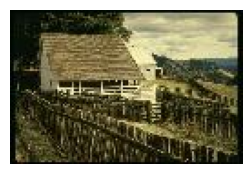

Top 10 results


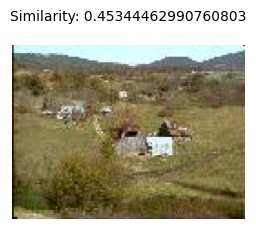

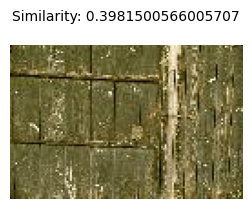

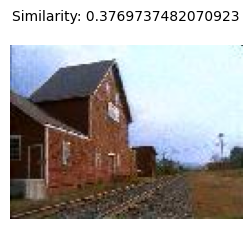

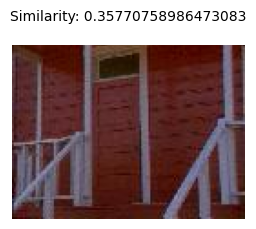

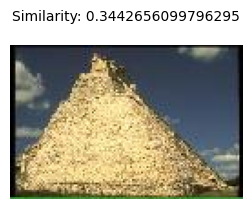

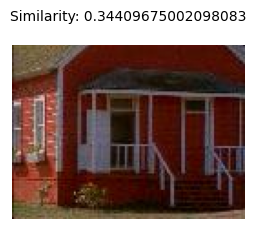

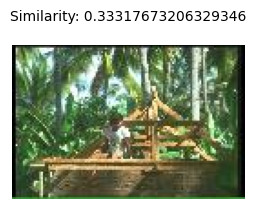

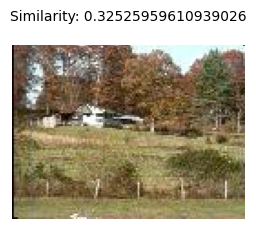

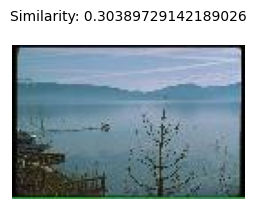

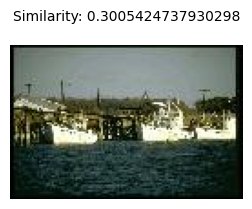

In [ ]:
query_image_paths = [
    '/content/images_mr/222.jpg'
]
top_k = 10

for query_image_path in query_image_paths:
    query_image = cv2.imread(query_image_path, 1)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    preprocessed_query_image = preprocessing(query_image).squeeze(0)

    ranked_list, scores = ranking(
        preprocessed_query_image,
        preprocessed_src_images,
        top_k
    )

    print('Query Image')
    plt.figure(figsize=(3, 3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()
    print(f'Top {top_k} results')
    for idx in range(len(ranked_list)):
        src_image_idx = ranked_list[idx]
        similarity_score = scores[idx]
        plt.figure(figsize=(3, 3))
        plt.imshow(src_images[src_image_idx])
        plt.title(f'Similarity: {similarity_score}\n', fontsize=10)
        plt.axis('off')
        plt.show()